# Comparison between the probands' location of marriage and their parents'

The goal of this Jupyter notebook is to provide a heatmap for supplementary figure 2 that compares the location of marriage of the probands with that of their parents.

In [1]:
import csv
import json
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

The paths to the datasets are found in the *paths.json* file.

In [2]:
with open("../paths.json", 'r') as file:
    paths = json.load(file)

The list of probands is loaded from the pickle generated at step 1.

In [3]:
with open(paths['wd'] + "results/pickles/balsac_pro_0.5_nosibs.pkl", 'rb') as file:
    pro = pickle.load(file)
len(pro)

26445

Load the expected kinship of BALSAC probands.

In [4]:
with open(paths['wd'] + "results/pickles/balsac_kin_0.5_nosibs.pkl", 'rb') as file:
    phi = pickle.load(file)

Create dictionaries for municipality and region codes.

In [5]:
city_code_to_string = {}
with open(paths['geography_definitions'], 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header row
    for row in reader:
        UrbMariage, UrbIdMariage, *_ = row
        city_code_to_string[int(UrbIdMariage)] = UrbMariage
region_code_to_string = {
    25705: "Abitibi",
    25706: "Bas-Saint-Laurent",
    25707: "Beauce",
    25708: "Bois-Francs",
    25709: "Charlevoix",
    25710: "Côte-de-Beaupré",
    25711: "Côte-du-Sud",
    25712: "Côte-Nord",
    25713: "Estrie",
    25714: "Gaspésie",
    25715: "Île-de-Montréal",
    25716: "Îles-de-la-Madeleine",
    25717: "Lanaudière",
    25718: "Laurentides",
    25719: "Mauricie",
    25720: "Outaouais",
    25721: "Agglomération de Québec",
    25722: "Région de Québec",
    25723: "Nord du Québec",
    25724: "Richelieu",
    25725: "Rive Nord-Ouest de Montréal",
    25726: "Rive Sud de Montréal",
    25727: "Saguenay–Lac-Saint-Jean",
    25728: "Témiscamingue",
    27118: "Côte-de-Beaupré",
    27119: "Portneuf",
    27120: "Lévis-Lotbinière"
}

Create dictionaries for proband and parent information.

In [6]:
city_proband = {}
region_proband = {}
year_proband = {}
city_parent = {}
region_parent = {}
year_parent = {}

with open(paths['demography_information'], 'r', encoding='cp1252') as file:
    reader = csv.reader(file, delimiter=';')
    next(reader)  # Skip header row
    for row in reader:
        if len(row) == 0: break
        IndID, CaG, ERRQ, PereID, MereID, Sexe, PaysOrigine, DateNaissance, RegionNaissance, \
        DateDeces, RegionDeces, DateMariage, ConjointID, URBMariage, RegionMariage, \
        DateMariageParents, URBMariageParents, RegionMariageParents = row

        IndID = int(IndID) if IndID != 'NA' else 0
        URBMariage = int(URBMariage) if URBMariage != 'NA' else 0
        RegionMariage = int(RegionMariage) if RegionMariage != 'NA' else 0
        DateMariage = int(DateMariage) if DateMariage != 'NA' else 0
        URBMariageParents = int(URBMariageParents) if URBMariageParents != 'NA' else 0
        RegionMariageParents = int(RegionMariageParents) if RegionMariageParents != 'NA' else 0
        DateMariageParents = int(DateMariageParents) if DateMariageParents != 'NA' else 0

        city_proband[IndID] = city_code_to_string.get(URBMariage, 0)
        region_proband[IndID] = region_code_to_string.get(RegionMariage, 0)
        year_proband[IndID] = DateMariage
        city_parent[IndID] = city_code_to_string.get(URBMariageParents, 0)
        region_parent[IndID] = region_code_to_string.get(RegionMariageParents, 0)
        year_parent[IndID] = DateMariageParents

Define the watercourse subdivisions.

In [7]:
city_to_water_boundary = {
    "Albanel": "Ashuapmushuan-Mistassini",
    "Alma": "East of Lac Saint-Jean",
    "Arvida": "South of Saguenay River",
    "Bégin": "North of Saguenay River",
    "Chambord": "Métabetchouane-Ashuapmushuan",
    "Chicoutimi": "South of Saguenay River",
    "Chicoutimi-Nord": "North of Saguenay River",
    "Chute-des-Passes": "Mistassini-Péribonka",
    "Delisle": "East of Lac Saint-Jean",
    "Desbiens": "La-Belle-Rivière–Métabetchouane",
    "Dolbeau": "Ashuapmushuan-Mistassini",
    "Ferland-et-Boilleau": "South of Saguenay River",
    "Girardville": "Ashuapmushuan-Mistassini",
    "Hébertville": "East of Lac Saint-Jean",
    "Hébertville-Station": "East of Lac Saint-Jean",
    "Jonquière": "South of Saguenay River",
    "L'Anse-Saint-Jean": "East of Ha! Ha!",
    "L'Ascension-de-Notre-Seigneur": "East of Lac Saint-Jean",
    "La Baie": "South of Saguenay River",
    "La Doré": "Métabetchouane-Ashuapmushuan",
    "Labrecque": "East of Lac Saint-Jean",
    "Lac-Bouchette": "Métabetchouane-Ashuapmushuan",
    "Lac-Kénogami": "South of Saguenay River",
    "Lac-à-la-Croix": "La-Belle-Rivière–Métabetchouane",
    "Larouche": "South of Saguenay River",
    "Laterrière": "South of Saguenay River",
    "Mashteuiatsh": "Métabetchouane-Ashuapmushuan",
    "Mistassini": "Mistassini-Péribonka",
    "Métabetchouan": "La-Belle-Rivière–Métabetchouane",
    "Mont-Apica": "East of Lac Saint-Jean",
    "Normandin": "Ashuapmushuan-Mistassini",
    "Notre-Dame-de-Lorette": "Mistassini-Péribonka",
    "Notre-Dame-du-Rosaire": "East of Lac Saint-Jean",
    "Petit-Saguenay": "East of Ha! Ha!",
    "Péribonka": "Mistassini-Péribonka",
    "Rivière-Éternité": "East of Ha! Ha!",
    "Roberval": "Métabetchouane-Ashuapmushuan",
    "Saint-Ambroise": "North of Saguenay River",
    "Saint-André-du-Lac-Saint-Jean": "La-Belle-Rivière–Métabetchouane",
    "Saint-Augustin-du-Lac-Saint-Jean": "Mistassini-Péribonka",
    "Saint-Bruno": "East of Lac Saint-Jean",
    "Saint-Charles-de-Bourget": "North of Saguenay River",
    "Saint-David-de-Falardeau": "North of Saguenay River",
    "Saint-Edmond": "Ashuapmushuan-Mistassini",
    "Saint-Eugène-du-Lac-Saint-Jean": "Mistassini-Péribonka",
    "Saint-François-de-Sales": "Métabetchouane-Ashuapmushuan",
    "Saint-Fulgence": "North of Saguenay River",
    "Saint-Félicien": "Métabetchouane-Ashuapmushuan",
    "Saint-Félix-d'Otis": "East of Ha! Ha!",
    "Saint-Gédéon": "East of Lac Saint-Jean",
    "Saint-Henri-de-Taillon": "East of Lac Saint-Jean",
    "Saint-Honoré-de-Chicoutimi": "North of Saguenay River",
    "Saint-Ludger-de-Milot": "Mistassini-Péribonka",
    "Saint-Méthode": "Ashuapmushuan-Mistassini",
    "Saint-Nazaire": "East of Lac Saint-Jean",
    "Saint-Prime": "Ashuapmushuan-Mistassini",
    "Saint-Stanislas-du-Lac-Saint-Jean": "Mistassini-Péribonka",
    "Saint-Thomas-Didyme": "Ashuapmushuan-Mistassini",
    "Sainte-Hedwidge": "Métabetchouane-Ashuapmushuan",
    "Sainte-Jeanne-d'Arc-du-Lac-Saint-Jean": "Mistassini-Péribonka",
    "Sainte-Monique-de-Honfleur": "East of Lac Saint-Jean",
    "Sainte-Rose-du-Nord": "North of Saguenay River",
    "Sainte-Élisabeth-de-Proulx": "Mistassini-Péribonka",
    "Shipshaw": "North of Saguenay River",
    "Val-Jalbert": "Métabetchouane-Ashuapmushuan",
    'Baie-Sainte-Catherine': 'Charlevoix',
    'Baie-Saint-Paul': 'Charlevoix',
    "Cap A L'aigle": 'Charlevoix',
    'Clermont': 'Charlevoix',
    'La Malbaie': 'Charlevoix',
    'Les Éboulements': 'Charlevoix',
    'Notre Dame Des Monts': 'Charlevoix',
    'Petite-Rivière-Saint-François': 'Charlevoix',
    'Pointe-au-Pic': 'Charlevoix',
    'St Aime Des Lacs': 'Charlevoix',
    "Saint-Bernard-de-l'Isle-aux-Coudres": 'Charlevoix',
    'Sainte-Agnès': 'Charlevoix',
    'Saint-Fidèle-de-Mont-Murray': 'Charlevoix',
    'Saint-Hilarion': 'Charlevoix',
    'Saint-Irénée': 'Charlevoix',
    'Saint-Joseph-de-la-Rive': 'Charlevoix',
    "Saint-Louis-de-l'Isle-aux-Coudres": 'Charlevoix',
    'Saint-Siméon': 'Charlevoix',
    'Saint-Urbain-de-Charlevoix': 'Charlevoix'
}

Get the watercourse subdivision of each proband.

In [8]:
subdivisions = [city_to_water_boundary[city_proband[ind]] for ind in pro]
subdivisions[:10]

['Mistassini-Péribonka',
 'South of Saguenay River',
 'South of Saguenay River',
 'South of Saguenay River',
 'South of Saguenay River',
 'East of Lac Saint-Jean',
 'East of Lac Saint-Jean',
 'South of Saguenay River',
 'South of Saguenay River',
 'South of Saguenay River']

Sort the watercourse subdivisions.

In [9]:
subdivisions_order = [
    "East of Ha! Ha!",
    "South of Saguenay River",
    "North of Saguenay River",
    "East of Lac Saint-Jean",
    "La-Belle-Rivière–Métabetchouane",
    "Mistassini-Péribonka",
    "Métabetchouane-Ashuapmushuan",
    "Ashuapmushuan-Mistassini"
]

Plot the heatmap.

In [10]:
parents_subdivisions = [city_to_water_boundary.get(city_parent[ind], "Outside Charlevoix/SLSJ") for ind in pro]
parents_subdivisions[:10]

['Métabetchouane-Ashuapmushuan',
 'Outside Charlevoix/SLSJ',
 'Charlevoix',
 'Outside Charlevoix/SLSJ',
 'Outside Charlevoix/SLSJ',
 'East of Lac Saint-Jean',
 'Métabetchouane-Ashuapmushuan',
 'South of Saguenay River',
 'South of Saguenay River',
 'South of Saguenay River']

In [11]:
migratory_df = pd.DataFrame({
    "Proband's subdivision of marriage": subdivisions,
    "Parents' subdivision of marriage": parents_subdivisions})
migratory_df

,Proband's subdivision of marriage,Parents' subdivision of marriage
0,Mistassini-Péribonka,Métabetchouane-Ashuapmushuan
1,South of Saguenay River,Outside Charlevoix/SLSJ
2,South of Saguenay River,Charlevoix
3,South of Saguenay River,Outside Charlevoix/SLSJ
4,South of Saguenay River,Outside Charlevoix/SLSJ
...,...,...
26440,South of Saguenay River,Outside Charlevoix/SLSJ
26441,Ashuapmushuan-Mistassini,Outside Charlevoix/SLSJ
26442,Ashuapmushuan-Mistassini,Outside Charlevoix/SLSJ
26443,East of Lac Saint-Jean,East of Lac Saint-Jean


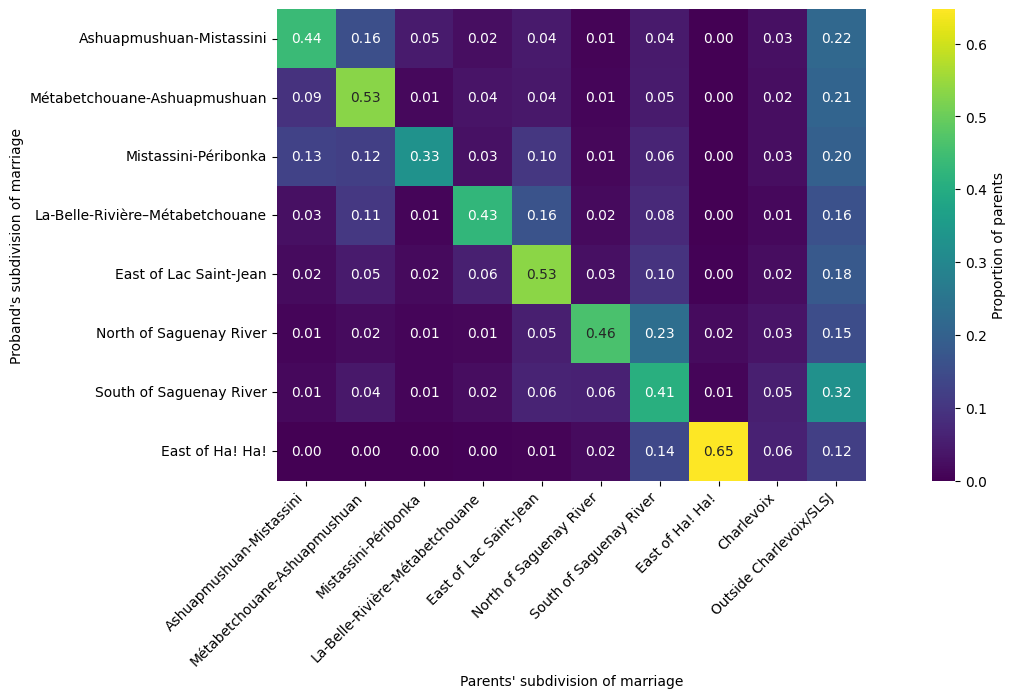

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig = plt.figure(figsize=(180*2/25.4, 90*2/25.4))

subdivisions_probands = [
    "Ashuapmushuan-Mistassini",
    "Métabetchouane-Ashuapmushuan",
    "Mistassini-Péribonka",
    "La-Belle-Rivière–Métabetchouane",
    "East of Lac Saint-Jean",
    "North of Saguenay River",
    "South of Saguenay River",
    "East of Ha! Ha!",
]

subdivisions_parents = [
    "Ashuapmushuan-Mistassini",
    "Métabetchouane-Ashuapmushuan",
    "Mistassini-Péribonka",
    "La-Belle-Rivière–Métabetchouane",
    "East of Lac Saint-Jean",
    "North of Saguenay River",
    "South of Saguenay River",
    "East of Ha! Ha!",
    "Charlevoix",
    "Outside Charlevoix/SLSJ"
]

count_table = pd.crosstab(
    migratory_df["Proband's subdivision of marriage"],
    migratory_df["Parents' subdivision of marriage"],
    rownames=['Proband'],
    colnames=['Parents'],
    dropna=False
).reindex(index=subdivisions_probands, columns=subdivisions_parents)

# Row-wise proportions
prop_table = count_table.div(count_table.sum(axis=1), axis=0)

sns.heatmap(
    prop_table,
    annot=True,
    fmt=".2f", 
    cmap="viridis",
    cbar=True
)

cbar = fig.get_axes()[0].collections[0].colorbar
cbar.set_label("Proportion of parents")
fig.get_axes()[0].set_xticklabels(fig.get_axes()[0].get_xticklabels(), rotation=45, ha='right')
fig.get_axes()[0].set_aspect('equal')  # Square cells
fig.get_axes()[0].set_ylabel("Proband's subdivision of marriage")
fig.get_axes()[0].set_xlabel("Parents' subdivision of marriage")

# Adjust layout and save
plt.tight_layout()

# Save the figure
plt.savefig(paths['wd'] + "results/supp_figures/2.MarriageHeatmap.svg", bbox_inches='tight', dpi=300)

plt.show()